# Criteo 1 TiB benchmark - Spark.ML random forest

Specialization of the experimental notebook for Spark.ML random forest.

# Table of contents

* [Configuration](#Configuration)
* [Distributed training](#Distributed-training)
* [End](#End)

In [1]:
%load_ext autotime
%matplotlib inline

from __future__ import print_function

time: 325 ms (started: 2022-11-16 23:46:29 +00:00)


## Configuration
[_(back to toc)_](#Table-of-contents)

Paths:

In [2]:
libsvm_data_remote_path = 'criteo/libsvm'
local_runtime_path = 'criteo/runtime'

time: 868 µs (started: 2022-11-16 23:46:31 +00:00)


In [3]:
import os


libsvm_train_template = os.path.join(libsvm_data_remote_path, 'train', '{}')
libsvm_test_template = os.path.join(libsvm_data_remote_path, 'test', '{}')

time: 1.1 ms (started: 2022-11-16 23:46:32 +00:00)


In [4]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

time: 404 µs (started: 2022-11-16 23:46:34 +00:00)


Samples to take:

In [5]:
train_samples = [
    10000, 30000,  # tens of thousands
    100000, 300000,  # hundreds of thousands
    1000000, 3000000,  # millions
    10000000, 30000000,  # tens of millions
    100000000, 300000000,  # hundreds of millions
    1000000000, 3000000000,  # billions
]

test_samples = [1000000]

time: 1.09 ms (started: 2022-11-16 23:46:35 +00:00)


Spark configuration and initialization:

In [6]:
executor_instances = 64
executor_cores = 4
memory_per_core = 4

time: 988 µs (started: 2022-11-16 23:46:37 +00:00)


In [7]:
app_name = 'Criteo experiment'

master = 'yarn'

settings = {
    'spark.network.timeout': '600',
    
    'spark.driver.cores': '16',
    'spark.driver.maxResultSize': '16G',
    'spark.driver.memory': '32G',
    
    'spark.executor.cores': str(executor_cores),
    'spark.executor.instances': str(executor_instances),
    'spark.executor.memory': str(memory_per_core * executor_cores) + 'G',
    
    'spark.speculation': 'true',
    
    'spark.yarn.queue': 'root.HungerGames',
}

time: 1.65 ms (started: 2022-11-16 23:46:38 +00:00)


In [8]:
import findspark
# 注意init中改为您的路spark安装路径
findspark.init('/data/dataset/fengwen/script/data/spark-3.3.1-bin-hadoop3-scala2.13')
from pyspark import SparkContext
sc = SparkContext('local','pyspark')
# PYSPARK_DRIVER_PYTHON 可以终端通过 whereis jupyter  指令查找路径
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/fengwen/miniconda3/envs/spark/bin/jupyter' # 自己的路径
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = " --ip=0.0.0.0 --port=7777"
# jupyter: /home/fengwen/miniconda3/envs/spark/bin/jupyter

22/11/16 23:46:41 WARN Utils: Your hostname, oneflow-27 resolves to a loopback address: 127.0.1.1; using 192.168.1.27 instead (on interface ens121f0)
22/11/16 23:46:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/16 23:46:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/16 23:46:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
time: 2.92 s (started: 2022-11-16 23:46:40 +00:00)


In [9]:
from pyspark.sql import SparkSession


builder = SparkSession.builder

builder.appName(app_name)
builder.master(master)
for k, v in settings.items():
    builder.config(k, v)

spark = builder.getOrCreate()
sc = spark.sparkContext

sc.setLogLevel('ERROR')

time: 135 ms (started: 2022-11-16 23:46:45 +00:00)


Logging:

In [10]:
import sys
import logging
from importlib import reload # 添加
logging.shutdown()            # 添加
reload(logging)


handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('[%(asctime)s] %(message)s')
handler.setFormatter(formatter)

ensure_directory_exists(local_runtime_path)
file_handler = logging.FileHandler(filename=os.path.join(local_runtime_path, 'mylog.log'), mode='a')
file_handler.setFormatter(formatter)

logger = logging.getLogger()
logger.addHandler(handler)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

time: 6.64 ms (started: 2022-11-16 23:51:52 +00:00)


In [11]:
logger.info('Spark version: %s.', spark.version)

[2022-11-16 23:51:54,592] Spark version: 3.3.1.
time: 4.07 ms (started: 2022-11-16 23:51:54 +00:00)


Plot measurements:

In [12]:
from functools import reduce
import pandas


def extract_data_for_plotting(df, what):
    return reduce(
        lambda left, right: pandas.merge(left, right, how='outer', on='Train size'),
        map(
            lambda name: df[df.Engine == name][['Train size', what]].rename(columns={what: name}),
            df.Engine.unique(),
        ),
    )   

def plot_stuff(df, what, ylabel=None, **kwargs):
    data = extract_data_for_plotting(df, what).set_index('Train size')
    ax = data.plot(marker='o', figsize=(6, 6), title=what, grid=True, linewidth=2.0, **kwargs)  # xlim=(1e4, 4e9)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

time: 131 ms (started: 2022-11-16 23:54:15 +00:00)


Let's name samples as their shortened "engineering" notation - 1e5 is 100k etc.:

In [13]:
def sample_name(sample):
    return str(sample)[::-1].replace('000', 'k')[::-1]

time: 992 µs (started: 2022-11-16 23:54:18 +00:00)


## Distributed training
[_(back to toc)_](#Table-of-contents)

Loading of LibSVM data as Spark.ML dataset:

In [25]:
from pyspark.ml.linalg import SparseVector


def parse_libsvm_line_for_rf(line):
    parts = line.split(' ')
    label = int(parts[0])
    indices, values = zip(*map(lambda s: s.split(':'), parts[1:]))
    return (label, SparseVector(40, indices,  values))


time: 2.28 ms (started: 2022-11-17 00:38:40 +00:00)


In [26]:
task_splitting = 1  # tasks per core

def load_ml_data_for_rf(template, sample):
    path = template.format(sample_name(sample))
    print("path", path)
    return sc.textFile(path).map(parse_libsvm_line_for_rf).toDF(['label', 'features']).repartition(int(executor_cores * executor_instances * task_splitting))

time: 2.39 ms (started: 2022-11-17 00:38:43 +00:00)


Evaluating a model:

In [17]:
from matplotlib import pyplot
from sklearn.metrics import auc, log_loss, roc_curve


def calculate_roc(predictions):
    labels, scores = zip(*predictions.rdd.map(lambda row: (row.label, row.probability[1])).collect())
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    ll = log_loss(labels, scores)
    return fpr, tpr, roc_auc, ll

def evaluate_model(name, model, test, train=None):
    metrics = dict()
    
    figure = pyplot.figure(figsize=(6, 6))
    ax = figure.gca()
    ax.set_title('ROC - ' + name)
    
    if train is not None:
        train_predictions = model.transform(train)
        train_fpr, train_tpr, train_roc_auc, train_log_loss = calculate_roc(train_predictions)
        
        metrics['train_roc_auc'] = train_roc_auc
        metrics['train_log_loss'] = train_log_loss
        
        ax.plot(train_fpr, train_tpr, linewidth=2.0, label='train (auc = {:.3f})'.format(train_roc_auc))
    
    test_predictions = model.transform(test)
    test_fpr, test_tpr, test_roc_auc, test_log_loss = calculate_roc(test_predictions)
    
    metrics['test_roc_auc'] = test_roc_auc
    metrics['test_log_loss'] = test_log_loss
    
    ax.plot(test_fpr, test_tpr, linewidth=2.0, label='test (auc = {:.3f})'.format(test_roc_auc))
    
    ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', c='gray')
    ax.legend()
    pyplot.show()
    
    return metrics

time: 189 ms (started: 2022-11-17 00:09:53 +00:00)


Models to work on:

In [18]:
from pyspark.ml.classification import (
    RandomForestClassifier, 
)

time: 857 µs (started: 2022-11-17 00:09:56 +00:00)


In [19]:
classifiers = {
    'rf': RandomForestClassifier(featureSubsetStrategy='sqrt', impurity='entropy', minInstancesPerNode=3, maxBins=64, maxDepth=10, numTrees=160),
}

time: 60.3 ms (started: 2022-11-17 00:09:57 +00:00)


Monkey-patch RDDs and DataFrames for context persistence:

In [27]:
import pyspark


def enter_method(self):
    self.persist()

def exit_method(self,exc_type, exc, traceback):
    self.unpersist()


pyspark.sql.dataframe.DataFrame.__enter__ = enter_method
pyspark.sql.dataframe.DataFrame.__exit__ = exit_method

time: 1.46 ms (started: 2022-11-17 00:38:47 +00:00)


Do distributed training:

[2022-11-17 00:39:04,197] Loading "1000000" test samples for rf.
path criteo/libsvm/test/1kk


[2022-11-17 00:39:07,246] Loaded "20" lines.
[2022-11-17 00:39:07,247] Working on "10000" train sample.
[2022-11-17 00:39:07,248] Loading "10000" train samples for rf.


path criteo/libsvm/train/10k


[2022-11-17 00:39:09,308] Loaded "460" lines.
[2022-11-17 00:39:09,310] Training a model "rf" on sample "10000".


[2022-11-17 00:39:38,414] Training a model "rf" on sample "10000" took "29.1031" seconds.
[2022-11-17 00:39:38,415] Evaluating the model "rf" trained on sample "10000".


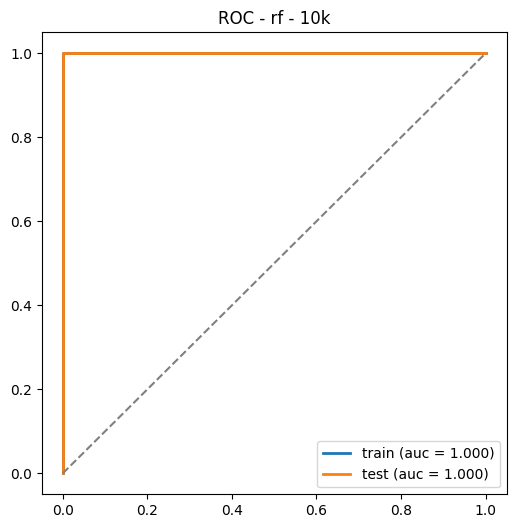

[2022-11-17 00:39:58,845] For the model "rf" trained on sample "10000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 9.992007221626413e-16, 'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:39:58,846] Data row: "rf	10000	1.0	9.992007221626413e-16	29.103107929229736".
[2022-11-17 00:39:58,904] Working on "30000" train sample.
[2022-11-17 00:39:58,905] Loading "30000" train samples for rf.
path criteo/libsvm/train/30k


[2022-11-17 00:40:00,718] Loaded "460" lines.
[2022-11-17 00:40:00,719] Training a model "rf" on sample "30000".


[2022-11-17 00:40:28,197] Training a model "rf" on sample "30000" took "27.4767" seconds.
[2022-11-17 00:40:28,198] Evaluating the model "rf" trained on sample "30000".


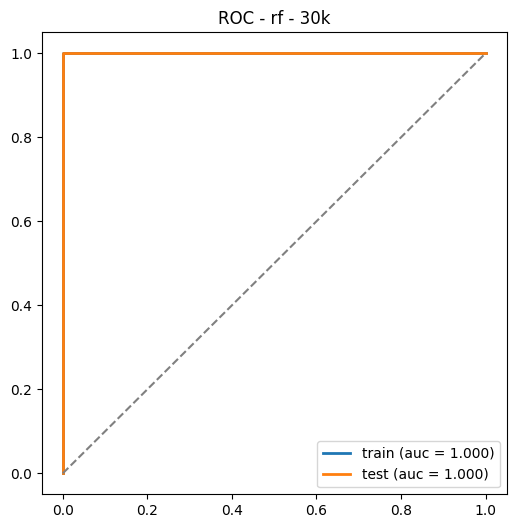

[2022-11-17 00:40:47,863] For the model "rf" trained on sample "30000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 9.992007221626413e-16, 'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:40:47,864] Data row: "rf	30000	1.0	9.992007221626413e-16	27.476683378219604".
[2022-11-17 00:40:47,867] Working on "100000" train sample.
[2022-11-17 00:40:47,868] Loading "100000" train samples for rf.
path criteo/libsvm/train/100k


[2022-11-17 00:40:49,621] Loaded "460" lines.
[2022-11-17 00:40:49,622] Training a model "rf" on sample "100000".


[2022-11-17 00:41:16,231] Training a model "rf" on sample "100000" took "26.6072" seconds.
[2022-11-17 00:41:16,232] Evaluating the model "rf" trained on sample "100000".


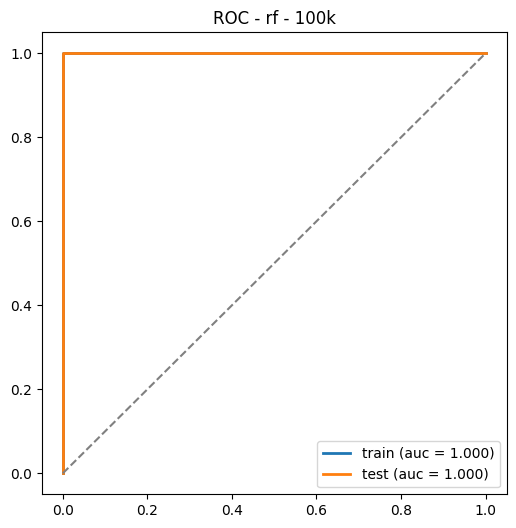

[2022-11-17 00:41:35,458] For the model "rf" trained on sample "100000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 9.992007221626413e-16, 'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:41:35,460] Data row: "rf	100000	1.0	9.992007221626413e-16	26.60716962814331".
[2022-11-17 00:41:35,464] Working on "300000" train sample.
[2022-11-17 00:41:35,466] Loading "300000" train samples for rf.
path criteo/libsvm/train/300k


[2022-11-17 00:41:37,181] Loaded "460" lines.
[2022-11-17 00:41:37,182] Training a model "rf" on sample "300000".


[2022-11-17 00:42:03,643] Training a model "rf" on sample "300000" took "26.4587" seconds.
[2022-11-17 00:42:03,645] Evaluating the model "rf" trained on sample "300000".


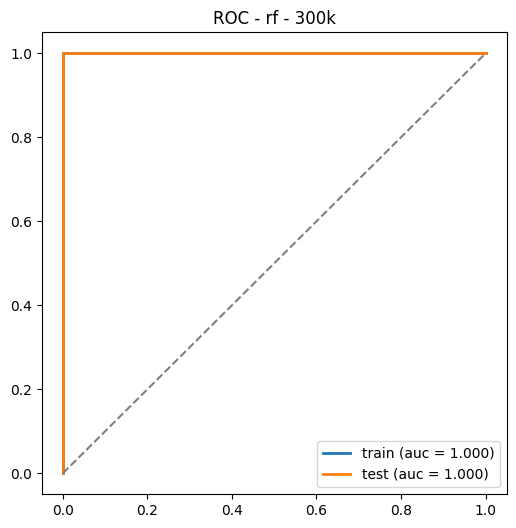

[2022-11-17 00:42:22,959] For the model "rf" trained on sample "300000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 9.992007221626413e-16, 'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:42:22,961] Data row: "rf	300000	1.0	9.992007221626413e-16	26.458736896514893".
[2022-11-17 00:42:22,964] Working on "1000000" train sample.
[2022-11-17 00:42:22,965] Loading "1000000" train samples for rf.
path criteo/libsvm/train/1kk


[2022-11-17 00:42:24,626] Loaded "460" lines.
[2022-11-17 00:42:24,627] Training a model "rf" on sample "1000000".


[2022-11-17 00:42:51,022] Training a model "rf" on sample "1000000" took "26.3928" seconds.
[2022-11-17 00:42:51,023] Evaluating the model "rf" trained on sample "1000000".


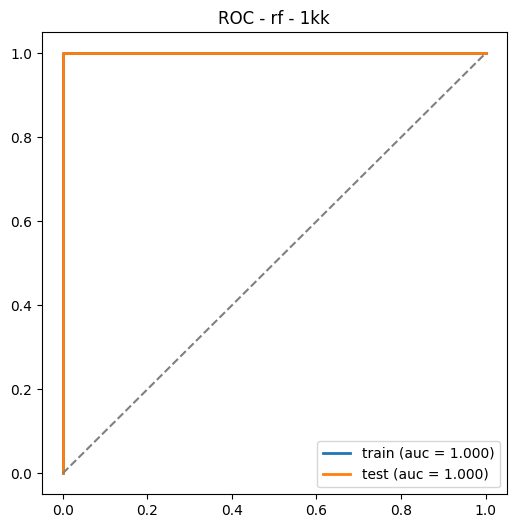

[2022-11-17 00:43:10,119] For the model "rf" trained on sample "1000000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 9.992007221626413e-16, 'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:43:10,121] Data row: "rf	1000000	1.0	9.992007221626413e-16	26.39281392097473".
[2022-11-17 00:43:10,124] Working on "3000000" train sample.
[2022-11-17 00:43:10,126] Loading "3000000" train samples for rf.
path criteo/libsvm/train/3kk


[2022-11-17 00:43:11,773] Loaded "460" lines.
[2022-11-17 00:43:11,774] Training a model "rf" on sample "3000000".


[2022-11-17 00:43:38,244] Training a model "rf" on sample "3000000" took "26.4689" seconds.
[2022-11-17 00:43:38,245] Evaluating the model "rf" trained on sample "3000000".


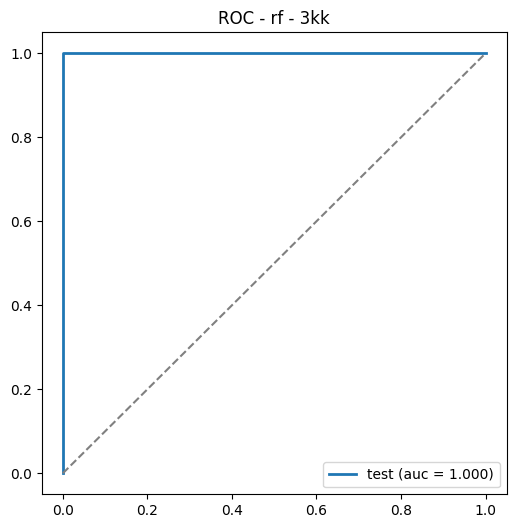

[2022-11-17 00:43:49,298] For the model "rf" trained on sample "3000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:43:49,300] Data row: "rf	3000000	1.0	9.992007221626413e-16	26.46885895729065".
[2022-11-17 00:43:49,303] Working on "10000000" train sample.
[2022-11-17 00:43:49,304] Loading "10000000" train samples for rf.
path criteo/libsvm/train/10kk


[2022-11-17 00:43:51,078] Loaded "460" lines.
[2022-11-17 00:43:51,080] Training a model "rf" on sample "10000000".


[2022-11-17 00:44:17,388] Training a model "rf" on sample "10000000" took "26.3071" seconds.
[2022-11-17 00:44:17,389] Evaluating the model "rf" trained on sample "10000000".


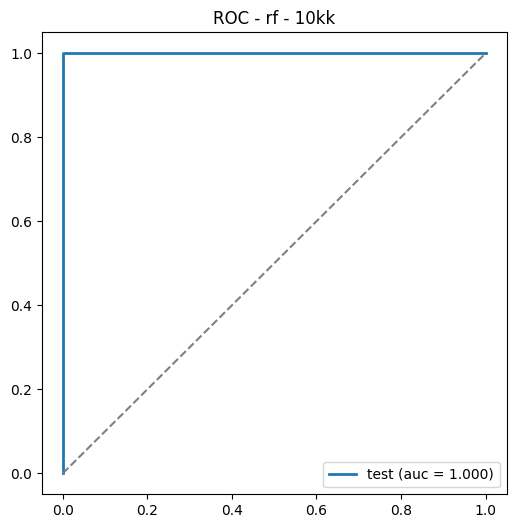

[2022-11-17 00:44:28,455] For the model "rf" trained on sample "10000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:44:28,457] Data row: "rf	10000000	1.0	9.992007221626413e-16	26.30705738067627".
[2022-11-17 00:44:28,459] Working on "30000000" train sample.
[2022-11-17 00:44:28,460] Loading "30000000" train samples for rf.
path criteo/libsvm/train/30kk


[2022-11-17 00:44:30,156] Loaded "460" lines.
[2022-11-17 00:44:30,157] Training a model "rf" on sample "30000000".


[2022-11-17 00:44:56,270] Training a model "rf" on sample "30000000" took "26.1123" seconds.
[2022-11-17 00:44:56,272] Evaluating the model "rf" trained on sample "30000000".


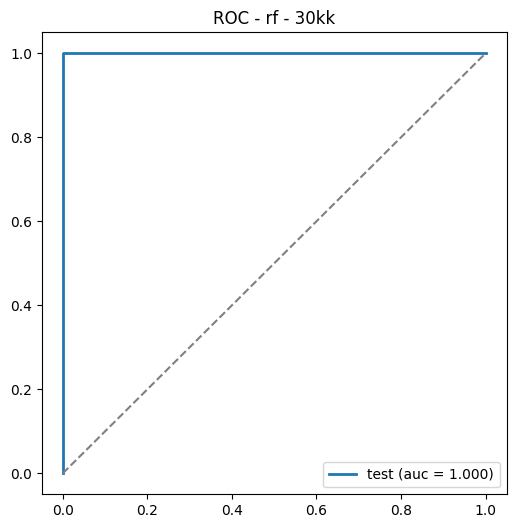

[2022-11-17 00:45:07,173] For the model "rf" trained on sample "30000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:45:07,174] Data row: "rf	30000000	1.0	9.992007221626413e-16	26.112316370010376".
[2022-11-17 00:45:07,177] Working on "100000000" train sample.
[2022-11-17 00:45:07,178] Loading "100000000" train samples for rf.
path criteo/libsvm/train/100kk


[2022-11-17 00:45:08,817] Loaded "460" lines.
[2022-11-17 00:45:08,818] Training a model "rf" on sample "100000000".


[2022-11-17 00:45:34,991] Training a model "rf" on sample "100000000" took "26.1714" seconds.
[2022-11-17 00:45:34,993] Evaluating the model "rf" trained on sample "100000000".


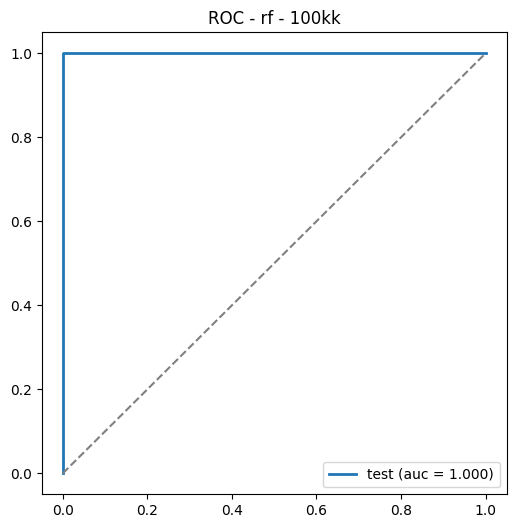

[2022-11-17 00:45:45,845] For the model "rf" trained on sample "100000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:45:45,846] Data row: "rf	100000000	1.0	9.992007221626413e-16	26.171390533447266".
[2022-11-17 00:45:45,849] Working on "300000000" train sample.
[2022-11-17 00:45:45,850] Loading "300000000" train samples for rf.
path criteo/libsvm/train/300kk


[2022-11-17 00:45:47,472] Loaded "460" lines.
[2022-11-17 00:45:47,474] Training a model "rf" on sample "300000000".


[2022-11-17 00:46:13,702] Training a model "rf" on sample "300000000" took "26.227" seconds.
[2022-11-17 00:46:13,703] Evaluating the model "rf" trained on sample "300000000".


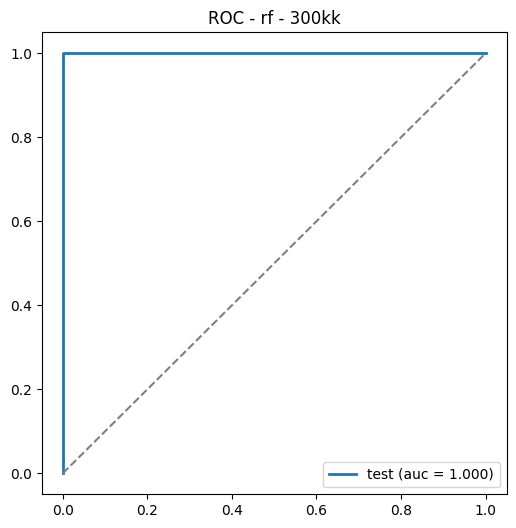

[2022-11-17 00:46:24,785] For the model "rf" trained on sample "300000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:46:24,787] Data row: "rf	300000000	1.0	9.992007221626413e-16	26.2270405292511".
[2022-11-17 00:46:24,791] Working on "1000000000" train sample.
[2022-11-17 00:46:24,792] Loading "1000000000" train samples for rf.
path criteo/libsvm/train/1kkk


[2022-11-17 00:46:26,469] Loaded "460" lines.
[2022-11-17 00:46:26,470] Training a model "rf" on sample "1000000000".


[2022-11-17 00:46:52,944] Training a model "rf" on sample "1000000000" took "26.4726" seconds.
[2022-11-17 00:46:52,945] Evaluating the model "rf" trained on sample "1000000000".


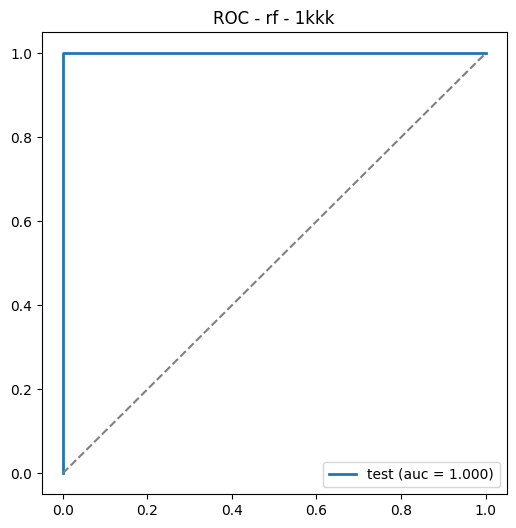

[2022-11-17 00:47:03,905] For the model "rf" trained on sample "1000000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:47:03,907] Data row: "rf	1000000000	1.0	9.992007221626413e-16	26.47263526916504".
[2022-11-17 00:47:03,910] Working on "3000000000" train sample.
[2022-11-17 00:47:03,911] Loading "3000000000" train samples for rf.
path criteo/libsvm/train/3kkk


[2022-11-17 00:47:05,588] Loaded "460" lines.
[2022-11-17 00:47:05,589] Training a model "rf" on sample "3000000000".


[2022-11-17 00:47:31,671] Training a model "rf" on sample "3000000000" took "26.0809" seconds.
[2022-11-17 00:47:31,672] Evaluating the model "rf" trained on sample "3000000000".


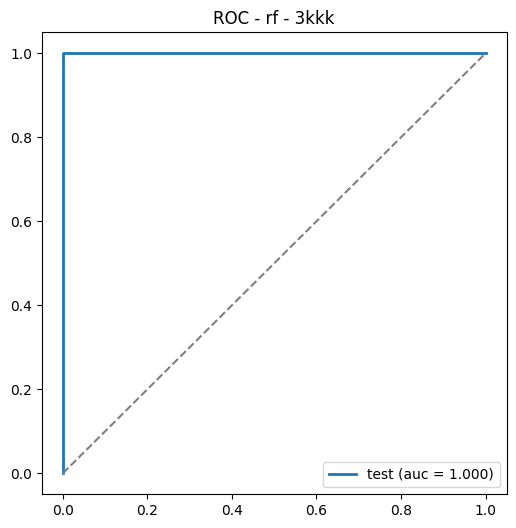

[2022-11-17 00:47:42,583] For the model "rf" trained on sample "3000000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 9.992007221626413e-16}"; ROC AUC calculated by Spark is "1.0".
[2022-11-17 00:47:42,585] Data row: "rf	3000000000	1.0	9.992007221626413e-16	26.08086085319519".
time: 8min 38s (started: 2022-11-17 00:39:04 +00:00)


In [29]:
import time

from pyspark.ml.evaluation import BinaryClassificationEvaluator


test_sample = test_samples[-1]

evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='probability', metricName='areaUnderROC')

new_quality_data = []
new_data_rows = []

logger.info('Loading "%s" test samples for rf.', test_sample)
test_df = load_ml_data_for_rf(libsvm_test_template, test_sample)
with test_df:
    logger.info('Loaded "%s" lines.', test_df.count())

    for train_sample in train_samples:

        logger.info('Working on "%s" train sample.', train_sample)

        logger.info('Loading "%s" train samples for rf.', train_sample)
        train_df = load_ml_data_for_rf(libsvm_train_template, train_sample)
        with train_df:
            logger.info('Loaded "%s" lines.', train_df.count())

            for classifier_name, classifier in classifiers.items():

                logger.info('Training a model "%s" on sample "%s".', classifier_name, train_sample)

                start = time.time()
                model = classifier.fit(train_df)
                duration = time.time() - start

                logger.info('Training a model "%s" on sample "%s" took "%g" seconds.', classifier_name, train_sample, duration)

                logger.info('Evaluating the model "%s" trained on sample "%s".', classifier_name, train_sample)
                metrics = evaluate_model(classifier_name + ' - ' + sample_name(train_sample), model, test_df, train=(train_df if train_sample <= 1000000 else None))

                test_predictions = model.transform(test_df)
                ml_metric_value = evaluator.evaluate(test_predictions)

                logger.info(
                    'For the model "%s" trained on sample "%s" metrics are: "%s"; ROC AUC calculated by Spark is "%s".',
                    classifier_name,
                    train_sample,
                    metrics,
                    ml_metric_value,
                )

                data_row = {
                    'Train size': train_sample,
                    'ROC AUC': metrics['test_roc_auc'],
                    'Log loss': metrics['test_log_loss'],
                    'Duration': duration,
                    'Engine': classifier_name,
                }
                new_quality_data.append(data_row)
                data_row_string = '\t'.join(str(data_row[field]) for field in ['Engine', 'Train size', 'ROC AUC', 'Log loss', 'Duration'])
                new_data_rows.append(data_row_string)
                logger.info('Data row: "%s".', data_row_string)

Plot metrics:

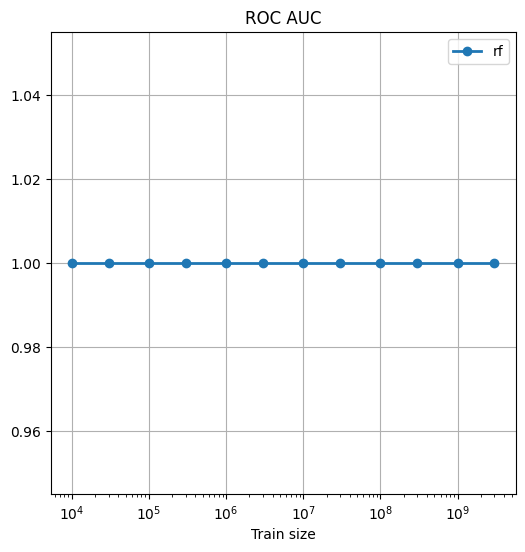

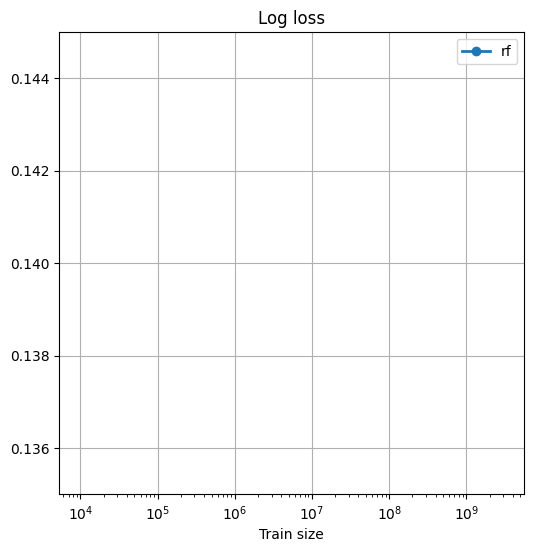

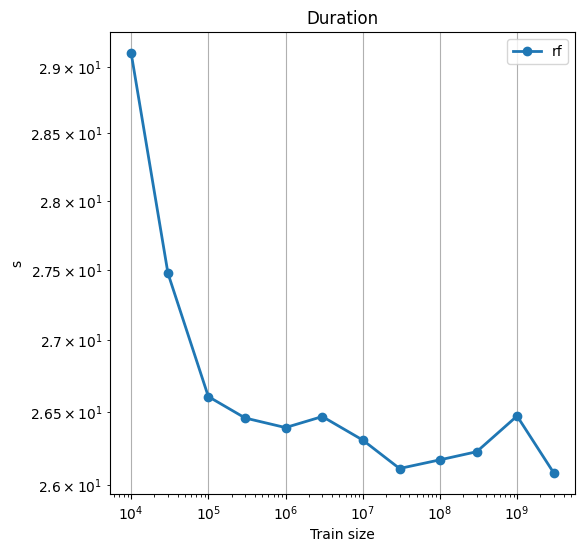

time: 1.23 s (started: 2022-11-17 00:48:20 +00:00)


In [30]:
measurements_df = pandas.DataFrame(new_quality_data).sort_values(by=['Train size'])
plot_stuff(measurements_df, 'ROC AUC', logx=True)
plot_stuff(measurements_df, 'Log loss', logx=True, ylim=(0.135, 0.145))
plot_stuff(measurements_df, 'Duration', loglog=True, ylabel='s')

In [31]:
for row in new_data_rows:
    print(row)

rf	10000	1.0	9.992007221626413e-16	29.103107929229736
rf	30000	1.0	9.992007221626413e-16	27.476683378219604
rf	100000	1.0	9.992007221626413e-16	26.60716962814331
rf	300000	1.0	9.992007221626413e-16	26.458736896514893
rf	1000000	1.0	9.992007221626413e-16	26.39281392097473
rf	3000000	1.0	9.992007221626413e-16	26.46885895729065
rf	10000000	1.0	9.992007221626413e-16	26.30705738067627
rf	30000000	1.0	9.992007221626413e-16	26.112316370010376
rf	100000000	1.0	9.992007221626413e-16	26.171390533447266
rf	300000000	1.0	9.992007221626413e-16	26.2270405292511
rf	1000000000	1.0	9.992007221626413e-16	26.47263526916504
rf	3000000000	1.0	9.992007221626413e-16	26.08086085319519
time: 2.24 ms (started: 2022-11-17 00:48:25 +00:00)


## End
[_(back to toc)_](#Table-of-contents)

Work done, stop Spark:

In [32]:
spark.stop()

time: 703 ms (started: 2022-11-17 00:48:29 +00:00)
